### Set up

In [1]:
import os
import sys


project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))  # lên 1 cấp từ notebooks/
if project_root not in sys.path:
    sys.path.append(project_root)

from utils.config_loader import load_config

config = load_config("/home/hungits/Study/DATN/Project/config/s3_config.yaml")
access_key = config["aws_access_key_id"]
secret_key = config["aws_secret_access_key"]
os.environ['AWS_ACCESS_KEY_ID'] = access_key 
os.environ['AWS_SECRET_ACCESS_KEY'] = secret_key

In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

### Other

In [ ]:
data_cleaned_path = config["output"]["s3_clean_path"]

spark = SparkSession.builder \
    .appName("YourAppName") \
    .config("spark.hadoop.fs.s3a.access.key", access_key) \
    .config("spark.hadoop.fs.s3a.secret.key", secret_key) \
    .getOrCreate()

df_ori = spark.read.option("header", True).csv(data_cleaned_path)

In [ ]:
unique_users_df = df_ori.select("User_ID").distinct()
unique_users_list = [row["User_ID"] for row in unique_users_df.collect()]
sampled_users_df = df_ori.select("User_ID").distinct().sample(withReplacement=False, fraction=0.05, seed=42)
df_5M = df_ori.join(sampled_users_df, on="User_ID", how="inner")

In [ ]:
# Check for null values in each column
from pyspark.sql.functions import col, sum as _sum
null_counts = df_5M.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df_5M.columns])
null_counts.show()

+-------+----------+-----------+--------+---------+--------+----+-----------+----+
|User_ID|Product_ID|Category_ID|Behavior|Timestamp|Datetime|Hour|Day_of_Week|Date|
+-------+----------+-----------+--------+---------+--------+----+-----------+----+
|      0|         0|          0|       0|        0|       0|   0|          0|   0|
+-------+----------+-----------+--------+---------+--------+----+-----------+----+



In [ ]:
# Check for duplicate rows
duplicate_count = df_5M.count() - df_5M.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 3


In [ ]:
df = df_5M.dropDuplicates()

In [ ]:
df_5M.coalesce(1).write.mode("overwrite").option("header", True).csv("file:///home/hungits/Study/DATN/Project/data/data_sample")

### EDA

In [3]:
df = pd.read_csv("/home/hungits/Study/DATN/Project/data/data_sample/part-00000-db25700d-f875-4fd5-876c-bf73b33f795b-c000.csv")

In [4]:
df.head()

,User_ID,Product_ID,Category_ID,Behavior,Timestamp,Datetime,Hour,Day_of_Week,Date
0,1009129,4568476,2736436,Buy,1511572827,2017-11-25T08:20:27.000+07:00,8,Saturday,2017-11-25
1,1009129,4314537,2736436,PageView,1511659660,2017-11-26T08:27:40.000+07:00,8,Sunday,2017-11-26
2,1009129,633559,1074254,PageView,1511659751,2017-11-26T08:29:11.000+07:00,8,Sunday,2017-11-26
3,1009129,3221295,1248986,PageView,1511660095,2017-11-26T08:34:55.000+07:00,8,Sunday,2017-11-26
4,1009129,633559,1074254,PageView,1511660326,2017-11-26T08:38:46.000+07:00,8,Sunday,2017-11-26


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008589 entries, 0 to 5008588
Data columns (total 9 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   User_ID      int64 
 1   Product_ID   int64 
 2   Category_ID  int64 
 3   Behavior     object
 4   Timestamp    int64 
 5   Datetime     object
 6   Hour         int64 
 7   Day_of_Week  object
 8   Date         object
dtypes: int64(5), object(4)
memory usage: 343.9+ MB


In [6]:
# Chuyển kiểu dữ liệu hợp lý
df["Behavior"] = df["Behavior"].astype("category")
df["Datetime"] = pd.to_datetime(df["Datetime"])
df["Day_of_Week"] = df["Day_of_Week"].astype("category")
df["Date"] = pd.to_datetime(df["Date"]).dt.date

In [7]:
# Top 5 Category_ID phổ biến nhất
df['Category_ID'].value_counts()[:5]

Category_ID
4756105    246152
4145813    172886
2355072    171171
3607361    162117
982926     154555
Name: count, dtype: int64

In [8]:
# Daily Count of "Buy" Behavior over Time
buy = df[df.Behavior == 'Buy']
buy_count = buy.groupby('Date').size().reset_index(name='count')
buy_count = buy_count.sort_values('Date')

In [9]:
# Day_of_week count of "Buy" Behavior over Time
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
buy_day_of_week = buy.groupby('Day_of_Week', observed=True).size().reset_index(name='count')
# used for ordinal data where the order matters
buy_day_of_week['Day_of_Week'] = pd.Categorical(buy_day_of_week['Day_of_Week'], categories=days_order, ordered=True)  
buy_day_of_week = buy_day_of_week.sort_values('Day_of_Week')
buy_day_of_week

,Day_of_Week,count
1,Monday,11138
5,Tuesday,10409
6,Wednesday,10903
4,Thursday,11297
0,Friday,10547
2,Saturday,22933
3,Sunday,22853


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.patches import Shadow
from matplotlib.lines import Line2D

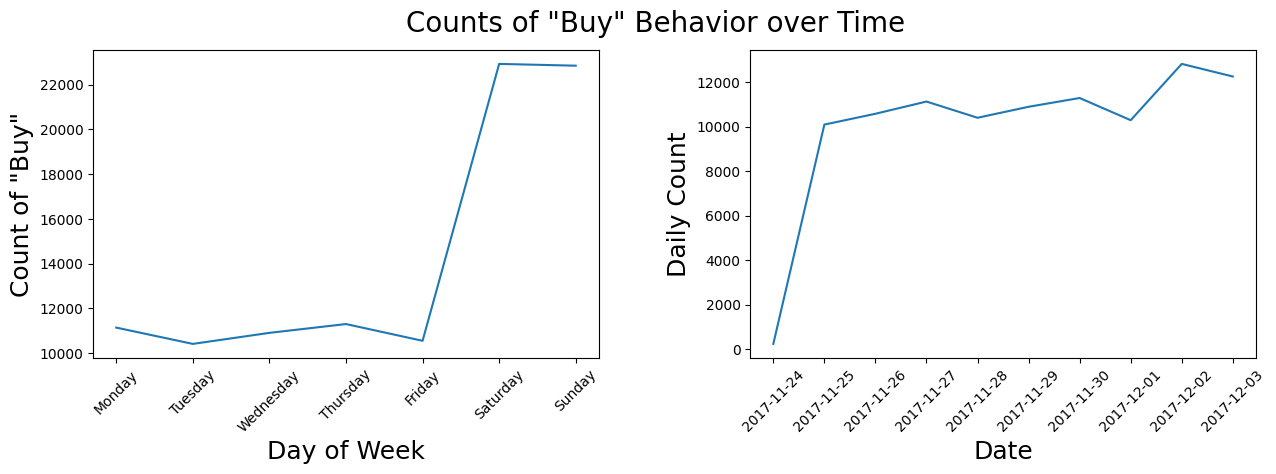

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Biểu đồ theo ngày
ax2.plot(buy_count['Date'], buy_count['count'])
ax2.set_xlabel('Date', fontsize=18)
ax2.set_ylabel('Daily Count', fontsize=18)
ax2.tick_params(axis='x', rotation=45)

# Biểu đồ theo thứ 
ax1.plot(buy_day_of_week['Day_of_Week'], buy_day_of_week['count'])
ax1.set_xlabel('Day of Week', fontsize=18)
ax1.set_ylabel('Count of "Buy"', fontsize=18)
ax1.tick_params(axis='x', rotation=45)

f.suptitle('Counts of "Buy" Behavior over Time', fontsize=20) 
plt.subplots_adjust(wspace=0.3)
plt.savefig('Buy_Count.png', format='png', bbox_inches='tight')

In [12]:
df['Day_of_Week'] = pd.Categorical(df['Day_of_Week'], categories=days_order, ordered=True)  
df = df.sort_values('Day_of_Week')
df


,User_ID,Product_ID,Category_ID,Behavior,Timestamp,Datetime,Hour,Day_of_Week,Date
2504294,583165,5032135,4145813,PageView,1511796462,2017-11-27 22:27:42+07:00,22,Monday,2017-11-27
2146183,210629,2466787,982926,PageView,1511746630,2017-11-27 08:37:10+07:00,8,Monday,2017-11-27
2146182,210629,550307,982926,Favorite,1511746619,2017-11-27 08:36:59+07:00,8,Monday,2017-11-27
2146181,210629,1902232,982926,PageView,1511746567,2017-11-27 08:36:07+07:00,8,Monday,2017-11-27
2146180,210629,1236831,982926,PageView,1511746557,2017-11-27 08:35:57+07:00,8,Monday,2017-11-27
...,...,...,...,...,...,...,...,...,...
1789319,862014,2741669,1297992,PageView,1511697223,2017-11-26 18:53:43+07:00,18,Sunday,2017-11-26
1789320,862014,4578982,1297992,PageView,1511697307,2017-11-26 18:55:07+07:00,18,Sunday,2017-11-26
1789321,862014,222419,1297992,PageView,1511697414,2017-11-26 18:56:54+07:00,18,Sunday,2017-11-26
3874453,906761,2773463,3108882,PageView,1512282494,2017-12-03 13:28:14+07:00,13,Sunday,2017-12-03


In [13]:
hourly_behavior = df.groupby(['Hour', 'Behavior'], observed=True).size().reset_index(name='Behavior_Count')
hourly_behavior_count = hourly_behavior.pivot_table(index='Hour', columns='Behavior', values='Behavior_Count', fill_value=0, observed=True)
hourly_behavior_count.reset_index(inplace=True)
hourly_behavior_count.head()

Behavior,Hour,AddToCart,Buy,Favorite,PageView
0,0,4341.0,1151.0,2593.0,71336.0
1,1,2199.0,586.0,1333.0,38505.0
2,2,1580.0,426.0,872.0,25190.0
3,3,1330.0,286.0,757.0,21966.0
4,4,1883.0,397.0,935.0,29544.0


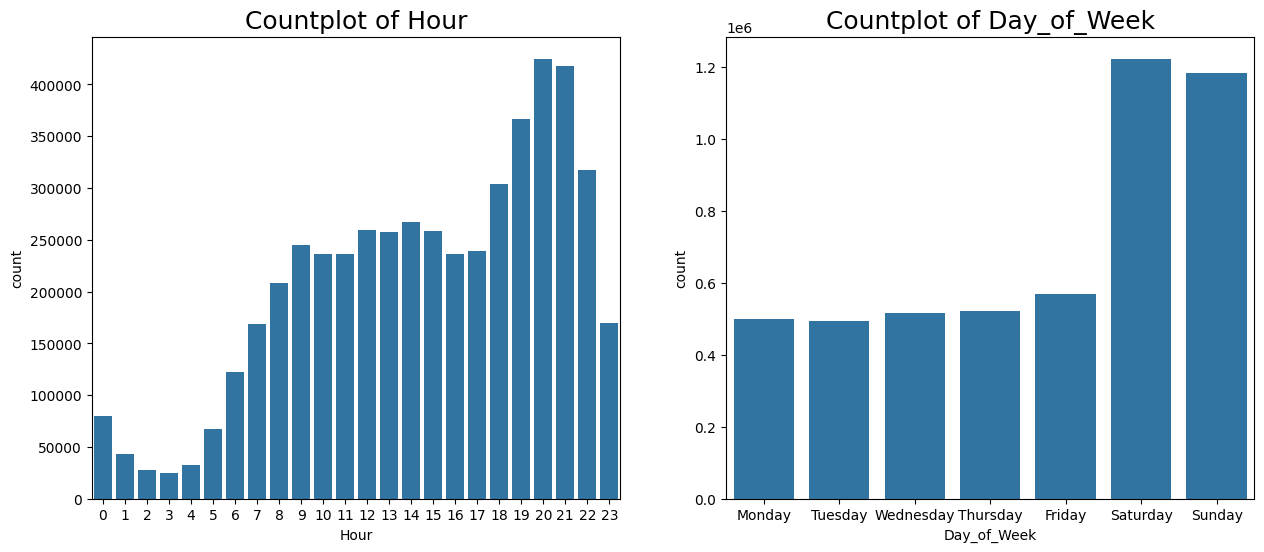

In [14]:
plt.figure(1, figsize=(15, 6))
n = 0 
for x in ['Hour', 'Day_of_Week']:    
    n += 1    
    plt.subplot(1, 2, n)    
    plt.subplots_adjust(hspace=0.5, wspace=0.2)    
    sns.countplot(data=df, x=x)    
    plt.title('Countplot of {}'.format(x), fontsize=18)
    
plt.savefig('Countplot of Hour and Day_of_Week.png', format='png', bbox_inches='tight')
plt.show()

In [15]:
# Calculate conversion rate for each category
conversion = df[df['Behavior'].isin(['Buy', 'PageView'])]
conversion_pb = conversion.groupby('Category_ID')['Behavior'].value_counts().unstack().fillna(0)
conversion_pb = conversion_pb[conversion_pb['PageView'] >= conversion_pb['Buy']]
conversion_pb['Conversion_Rate'] = conversion_pb['Buy'] / (conversion_pb['Buy'] + conversion_pb['PageView'])
conversion_pb.head()

Behavior,AddToCart,Buy,Favorite,PageView,Conversion_Rate
Category_ID,,,,,
2171,0,1,0,58,0.016949
2410,0,2,0,34,0.055556
2818,0,0,0,1,0.000000
4907,0,1,0,16,0.058824
5064,0,10,0,1410,0.007042


In [16]:
# the conversion rate of the top 10 sale categories
conversion_10 = conversion_pb.sort_values(by='Buy', ascending=False)[:10]
conversion_10


Behavior,AddToCart,Buy,Favorite,PageView,Conversion_Rate
Category_ID,,,,,
1464116,0,1753,0,33642,0.049527
2735466,0,1683,0,56861,0.028748
4145813,0,1585,0,157345,0.009973
2885642,0,1574,0,47201,0.032271
4756105,0,1458,0,227003,0.006382
4801426,0,1366,0,94679,0.014222
982926,0,1254,0,141025,0.008814
4159072,0,926,0,9641,0.087631
1320293,0,919,0,91203,0.009976


In [17]:
top10_pv_categories = df[df['Behavior'] == 'PageView'].groupby('Category_ID').size().reset_index(name='PageView Count').sort_values(by='PageView Count', ascending=False)[:10]
top10_pv_categories

,Category_ID,PageView Count
6845,4756105,227003
3364,2355072,159998
5995,4145813,157345
5207,3607361,152255
1404,982926,141025
3577,2520377,102367
6916,4801426,94679
1871,1320293,91203
3507,2465336,74142
4290,3002561,70315


In [18]:
top10_buy_categories = df[df['Behavior'] == 'Buy'].groupby('Category_ID').size().reset_index(name='Buy Count').sort_values(by='Buy Count', ascending=False)[:10]
top10_buy_categories

,Category_ID,Buy Count
1202,1464116,1753
2214,2735466,1683
3374,4145813,1585
2330,2885642,1574
3867,4756105,1458
3907,4801426,1366
811,982926,1254
3384,4159072,926
1080,1320293,919
2132,2640118,891


### Customer Segmentation

In [19]:
# 1. Calculate recency
recency = df[df['Behavior'] == 'Buy'].groupby(by='User_ID', as_index=False)['Date'].max()
recency.columns = ['User_ID', 'LastPurshaceDate']
current_date = df[df['Behavior'] == 'Buy']['Date'].max()
recency['Recency'] = recency['LastPurshaceDate'].apply(lambda x: (current_date - x).days)
recency.head()

,User_ID,LastPurshaceDate,Recency
0,4,2017-11-30,3
1,39,2017-12-02,1
2,81,2017-11-29,4
3,91,2017-12-03,0
4,119,2017-11-29,4


In [20]:
# 2. Calculate Frequency
frequency = df[df['Behavior'] == 'Buy'].groupby('User_ID')['Behavior'].count().reset_index()
frequency.columns = ['User_ID', 'Frequency']
frequency.head()

,User_ID,Frequency
0,4,4
1,39,5
2,81,2
3,91,2
4,119,3


In [21]:
# 3. Create RFM table
rfm = recency.merge(frequency, on='User_ID')
rfm.drop(columns=['LastPurshaceDate'], inplace=True)
rfm.head()

,User_ID,Recency,Frequency
0,4,3,4
1,39,1,5
2,81,4,2
3,91,0,2
4,119,4,3


In [22]:
# 4. Assign R, F quartile values
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()
def r_score(x):    
    if x <= quantiles['Recency'][0.25]:        
        return 4    
    elif x <= quantiles['Recency'][0.5]:        
        return 3    
    elif x <= quantiles['Recency'][0.75]:        
        return 2    
    else:        
        return 1
    
def f_score(x):    
    if x <= quantiles['Frequency'][0.25]:        
        return 1    
    elif x <= quantiles['Frequency'][0.5]:        
        return 2    
    elif x <= quantiles['Frequency'][0.75]:        
        return 3    
    else:        
        return 4

rfm['R_score'] = rfm['Recency'].apply(r_score)
rfm['F_score'] = rfm['Frequency'].apply(f_score)
rfm.head()

,User_ID,Recency,Frequency,R_score,F_score
0,4,3,4,2,3
1,39,1,5,4,4
2,81,4,2,2,2
3,91,0,2,4,2
4,119,4,3,2,3


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [24]:
rfm_val = rfm[['Recency', 'Frequency']]
scaler = StandardScaler()
rfm_scaled = scaler.fit(rfm_val)
rfm_scaled = scaler.fit_transform(rfm_val)

<Figure size 600x400 with 0 Axes>

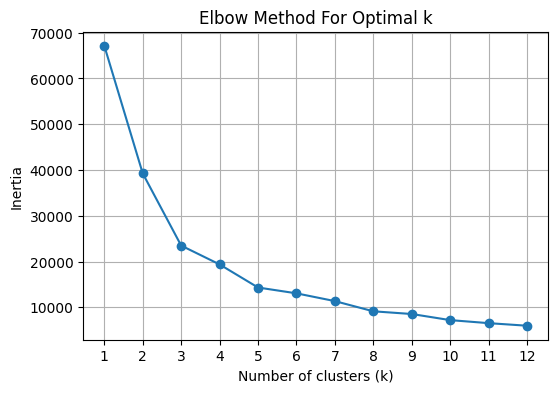

In [25]:
# determine the number of clusters using Elbow method
plt.figure(figsize=(6, 4))
inertia = []
# Calculate inertia for different number of clusters
for k in range(1, 13):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(range(1, 13), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 13))
plt.grid(True)
plt.savefig('Elbow_Plot.png')
plt.show()

Choose K = 3

In [26]:
kmeans_scaled = KMeans(3)
kmeans_scaled.fit(rfm_scaled)
identified_clusters = kmeans_scaled.fit_predict(rfm_val)
rfm['Cluster'] = kmeans_scaled.fit_predict(rfm_scaled)
rfm.head()

,User_ID,Recency,Frequency,R_score,F_score,Cluster
0,4,3,4,2,3,1
1,39,1,5,4,4,1
2,81,4,2,2,2,2
3,91,0,2,4,2,1
4,119,4,3,2,3,2


In [27]:
# Filter the original dataset based on cluster labels
cluster_0 = rfm[rfm['Cluster'] == 0]
cluster_1 = rfm[rfm['Cluster'] == 1]
cluster_2 = rfm[rfm['Cluster'] == 2]

In [28]:
cluster_0.describe()

,User_ID,Recency,Frequency,R_score,F_score,Cluster
count,3.913000e+03,3913.000000,3913.000000,3913.000000,3913.0,3913.0
mean,5.134071e+05,1.098646,8.700741,3.520572,4.0,0.0
std,2.912062e+05,1.371817,4.271660,0.818778,0.0,0.0
min,1.310000e+02,0.000000,6.000000,1.000000,4.0,0.0
25%,2.627530e+05,0.000000,6.000000,3.000000,4.0,0.0
50%,5.219740e+05,1.000000,7.000000,4.000000,4.0,0.0
75%,7.599040e+05,2.000000,10.000000,4.000000,4.0,0.0
max,1.017726e+06,8.000000,90.000000,4.000000,4.0,0.0


In [ ]:
def categorize_customers(row):    
    if row['Cluster'] == 0:        
        return 'Churn Risk Customers'    
    elif row['Cluster'] == 1:        
        return 'Potential Customers'    
    elif row['Cluster'] == 2:        
        return 'High-Value Customers'

rfm['class'] = rfm.apply(categorize_customers, axis=1)

In [30]:
rfm.head()

,User_ID,Recency,Frequency,R_score,F_score,Cluster,class
0,4,3,4,2,3,1,Potential Customers
1,39,1,5,4,4,1,Potential Customers
2,81,4,2,2,2,2,High-Value Customers
3,91,0,2,4,2,1,Potential Customers
4,119,4,3,2,3,2,High-Value Customers


In [31]:
customer_class = rfm.groupby('class')['User_ID'].count().reset_index()
customer_class.columns = ['Customer Class', 'Counts']
customer_class.head()

,Customer Class,Counts
0,Churn Risk Customers,3913
1,High-Value Customers,10427
2,Potential Customers,19230


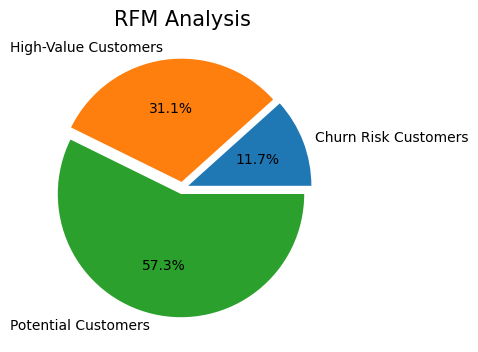

In [32]:
plt.figure(figsize=(4, 4))
plt.pie(customer_class['Counts'], labels=customer_class['Customer Class'], autopct='%1.1f%%', explode=[0.05]*3)
plt.title('RFM Analysis', fontsize=15)
plt.savefig('RFM Analysis.png', format='png', bbox_inches='tight')
plt.show()

### Predictive Behavior Modeling

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [34]:
df_time = df.sort_values(by=['User_ID', 'Datetime'])
behavior_count = df_time.groupby(['Product_ID', 'User_ID'])['Behavior'].size().reset_index(name='Behavior_Count')
filtered_bc = behavior_count[behavior_count['Behavior_Count'] >= 5]
df_filtered = df_time.merge(filtered_bc, on=['Product_ID', 'User_ID'])
df_filtered.head()

,User_ID,Product_ID,Category_ID,Behavior,Timestamp,Datetime,Hour,Day_of_Week,Date,Behavior_Count
0,4,4060948,2465336,PageView,1511865022,2017-11-28 17:30:22+07:00,17,Tuesday,2017-11-28,14
1,4,572096,2465336,PageView,1511865076,2017-11-28 17:31:16+07:00,17,Tuesday,2017-11-28,12
2,4,4060948,2465336,PageView,1511865219,2017-11-28 17:33:39+07:00,17,Tuesday,2017-11-28,14
3,4,2102225,4145813,PageView,1511865839,2017-11-28 17:43:59+07:00,17,Tuesday,2017-11-28,13
4,4,2102225,4145813,PageView,1511866131,2017-11-28 17:48:51+07:00,17,Tuesday,2017-11-28,13


In [35]:
sequence = df_filtered.groupby(['Product_ID', 'User_ID'])['Behavior'].apply(list).reset_index(name='Sequence')
sequence.drop(columns=['Product_ID'], inplace=True)
sequence.head()

,User_ID,Sequence
0,85537,"[AddToCart, AddToCart, PageView, PageView, Pag..."
1,13004,"[PageView, PageView, Buy, PageView, PageView, ..."
2,162599,"[PageView, PageView, PageView, PageView, PageV..."
3,380719,"[Favorite, PageView, PageView, PageView, PageV..."
4,641658,"[PageView, PageView, PageView, PageView, PageV..."


In [36]:
sequence_train, sequence_test = train_test_split(sequence, test_size=0.2, random_state=42)
sequence_val, sequence_test = train_test_split(sequence_test, test_size=0.5, random_state=42)

In [37]:
sequence_train.head()

,User_ID,Sequence
10609,791235,"[AddToCart, PageView, PageView, PageView, Page..."
52180,673650,"[Buy, PageView, PageView, AddToCart, PageView]"
27184,25576,"[AddToCart, AddToCart, PageView, PageView, Pag..."
48179,278487,"[PageView, PageView, PageView, Buy, PageView, ..."
61654,35204,"[AddToCart, PageView, PageView, PageView, Page..."


In [ ]:
PADDING_IDX = 4
class UserBehaviorDataset(Dataset):    
    def __init__(self, dataframe):        
        self.dataframe = dataframe        
        self.token_to_idx = {'PageView': 0, 'AddToCart': 1, 'Buy': 2, 'Favorite': 3,  'Padding': PADDING_IDX}    
    
    def __len__(self):        
        return len(self.dataframe)
    
    def __getitem__(self, idx):       
        sequence = self.dataframe.iloc[idx, 1]        
        sequence_idx = [self.token_to_idx[action] for action in sequence]        
        return torch.tensor(sequence_idx), torch.tensor(len(sequence_idx))
        
def pad_collate(batch):    
    (xx, yy) = zip(*batch)    
    x_lens = torch.tensor(yy)    
    xx_pad = torch.nn.utils.rnn.pad_sequence(xx, batch_first=True, padding_value=PADDING_IDX)    
    return xx_pad, x_lens

train_dataset = UserBehaviorDataset(sequence_train)
val_dataset = UserBehaviorDataset(sequence_val)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate)



In [ ]:
# Hyper-parameters
class LSTMBehaviorModel(nn.Module):    
    def __init__(self, num_tokens, hidden_size=128, num_layers=2, dropout=0.3):        
        super(LSTMBehaviorModel, self).__init__()        
        self.hidden_size = hidden_size        
        self.num_layers = num_layers        
        self.embed = nn.Embedding(num_tokens, hidden_size)        
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)     
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_tokens)

    def forward(self, x, x_lens):        
        x = self.embed(x)        
        packed_x = pack_padded_sequence(x, x_lens.cpu(), batch_first=True, enforce_sorted=False)        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)        
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)        
        packed_out, _ = self.lstm(packed_x, (h0, c0))        
        out, _ = pad_packed_sequence(packed_out, batch_first=True)        
        out = self.fc(out)        
        return out
    
model = LSTMBehaviorModel(num_tokens=5).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=PADDING_IDX, reduction='none').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
num_epochs = 5  
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):    
    model.train()    
    for x_padded, x_lens in tqdm(train_loader):       
        x_padded, x_lens = x_padded.to(device), x_lens.to(device)        
        optimizer.zero_grad()        
        output = model(x_padded, x_lens)        
        loss = criterion(output.view(-1, 5), x_padded.view(-1))        
        loss = loss.view(x_padded.size(0), -1).sum(dim=1).mean()        
        train_loss_list.append(loss.item())        
        loss.backward()        
        optimizer.step()    
        
    model.eval()    
    total_val_loss = 0    
    with torch.no_grad():        
        for x_padded, x_lens in val_loader:            
            x_padded, x_lens = x_padded.to(device), x_lens.to(device)            
            output = model(x_padded, x_lens)            
            val_loss = criterion(output.view(-1, 5), x_padded.view(-1))            
            val_loss = val_loss / x_padded.size(0)
            val_loss = val_loss.view(x_padded.size(0), -1).sum(dim=1).mean()            
            total_val_loss += val_loss.item()    
            
    avg_val_loss = total_val_loss / len(val_loader)    
    print(f"Epoch {epoch}: Avg. Validation Loss: {avg_val_loss}")    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss        
        torch.save(model.state_dict(), 'best_model.pth')

  0%|          | 0/1588 [00:00<?, ?it/s]

100%|██████████| 1588/1588 [00:12<00:00, 128.60it/s]


Epoch 0: Avg. Validation Loss: 1.1574950299039863e-05


100%|██████████| 1588/1588 [00:12<00:00, 124.34it/s]


Epoch 1: Avg. Validation Loss: 2.781345004556746e-06


100%|██████████| 1588/1588 [00:10<00:00, 152.52it/s]


Epoch 2: Avg. Validation Loss: 9.917023899517754e-07


100%|██████████| 1588/1588 [00:11<00:00, 139.99it/s]


Epoch 3: Avg. Validation Loss: 3.9852195695560447e-07


100%|██████████| 1588/1588 [00:10<00:00, 151.78it/s]


Epoch 4: Avg. Validation Loss: 1.6458021145357424e-07


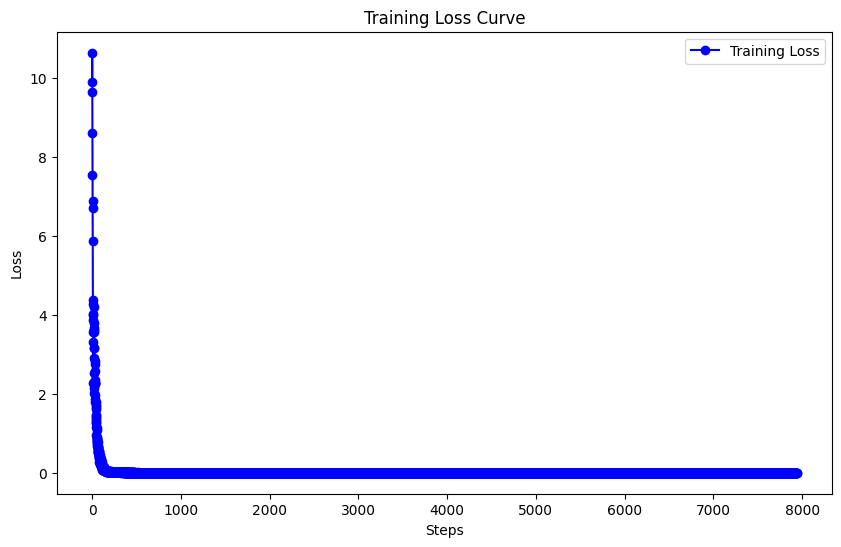

In [48]:
# plot training loss curve
plt.figure(figsize=(10, 6))
plt.plot(list(range(0, len(train_loss_list))), train_loss_list, marker='o', color='b', label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.savefig("loss.png", dpi=600)
plt.show()

In [49]:
test_df = sequence_test 
test_dataset = UserBehaviorDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate)

model.eval()

all_predictions = []
all_labels = []
with torch.no_grad():    
    for x_padded, x_lens in test_loader:        
        x_padded, x_lens = x_padded.to(device), x_lens.to(device)        
        output = model(x_padded, x_lens)        
        preds = output.argmax(dim=-1)          
        for i, length in enumerate(x_lens):
            all_predictions.append(preds[i, length - 1].item())            
            all_labels.append(x_padded[i, length - 1].item())

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 1.0


In [51]:
# rnn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class RNNBehaviorModel(nn.Module):    
    def __init__(self, num_tokens, hidden_size=128, num_layers=1):        
        super(RNNBehaviorModel, self).__init__()        
        self.hidden_size = hidden_size        
        self.num_layers = num_layers        
        self.embed = nn.Embedding(num_tokens, hidden_size)        
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)        
        self.fc = nn.Linear(hidden_size, num_tokens)    
    def forward(self, x, x_lens):        
        x = self.embed(x)        
        packed_x = pack_padded_sequence(x, x_lens.cpu(), batch_first=True, enforce_sorted=False)        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)        
        packed_out, _ = self.rnn(packed_x, h0)        
        out, _ = pad_packed_sequence(packed_out, batch_first=True)        
        out = self.fc(out)        
        return out

model = RNNBehaviorModel(num_tokens=5).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=PADDING_IDX, reduction='none').to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
best_val_loss = float('inf')
num_epochs = 5

for epoch in range(num_epochs):    
    model.train()    
    for x_padded, x_lens in tqdm(train_loader):        
        x_padded, x_lens = x_padded.to(device), x_lens.to(device)        
        optimizer.zero_grad()        
        output = model(x_padded, x_lens)        
        loss = criterion(output.view(-1, 5), x_padded.view(-1))        
        #loss = loss / x_padded.size(0)
        loss = loss.view(x_padded.size(0), -1).sum(dim=1).mean()        
        loss.backward()        
        optimizer.step()

    model.eval()    
    total_val_loss = 0

    with torch.no_grad():        
        for x_padded, x_lens in val_loader:            
            x_padded, x_lens = x_padded.to(device), x_lens.to(device)            
            output = model(x_padded, x_lens)            
            val_loss = criterion(output.view(-1, 5), x_padded.view(-1))           
            val_loss = val_loss.view(x_padded.size(0), -1).sum(dim=1).mean()            
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)    
    print(f"Epoch {epoch}: Avg. Validation Loss: {avg_val_loss}")   
    if avg_val_loss < best_val_loss:        
        best_val_loss = avg_val_loss        
        torch.save(model.state_dict(), 'best_model.pth')

100%|██████████| 1588/1588 [00:09<00:00, 171.73it/s]


Epoch 0: Avg. Validation Loss: 0.0004563073688490906


100%|██████████| 1588/1588 [00:10<00:00, 149.51it/s]


Epoch 1: Avg. Validation Loss: 0.00011377035306436689


100%|██████████| 1588/1588 [00:11<00:00, 140.96it/s]


Epoch 2: Avg. Validation Loss: 4.173512581528759e-05


100%|██████████| 1588/1588 [00:12<00:00, 132.07it/s]


Epoch 3: Avg. Validation Loss: 1.6962107974676422e-05


100%|██████████| 1588/1588 [00:10<00:00, 147.75it/s]


Epoch 4: Avg. Validation Loss: 7.302643998582197e-06


In [53]:
model = RNNBehaviorModel(num_tokens=5).to(device)
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():    
    for x_padded, x_lens in test_loader:        
        x_padded, x_lens = x_padded.to(device), x_lens.to(device)        
        output = model(x_padded, x_lens)        
        preds = output.argmax(dim=-1)         
        for i, length in enumerate(x_lens):            
            all_predictions.append(preds[i, length - 1].item())            
            all_labels.append(x_padded[i, length - 1].item())            
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.02739294710327456


In [ ]:
spark = SparkSession.builder \
        .appName("UserBehaviorETLPipeline") \
        .config("spark.driver.memory", "2g") \
        .config("spark.executor.memory", "2g") \
        .config("spark.hadoop.fs.defaultFS", "file:///") \
        .getOrCreate()
local_path = "/home/hungits/Study/DATN/Project/data/raw/UserBehavior.csv"
column_names = ["User_ID", "Product_ID", "Category_ID", "Behavior", "Timestamp"]
df = spark.read.option("header", False).csv(local_path).toDF(*column_names)

25/05/16 02:00:36 WARN Utils: Your hostname, TRONGHUNG resolves to a loopback address: 127.0.1.1; using 192.168.0.104 instead (on interface wlp0s20f3)
25/05/16 02:00:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/16 02:00:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sampled_users_df = df.select("User_ID").distinct().sample(withReplacement=False, fraction=0.01, seed=42)
df = df.join(sampled_users_df, on="User_ID", how="inner")

In [4]:
path = "/home/hungits/Study/DATN/Project/data/processed"
df.coalesce(1).write.mode('overwrite').option("header", True).csv(path)